In [7]:
from qiskit import QuantumCircuit, IBMQ, Aer, assemble, transpile
from qiskit.circuit.library import MCMT
from qiskit.visualization import plot_histogram
from qiskit_textbook.problems import grover_problem_oracle
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib
import random

IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-11-03 21:52:56,768: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [8]:
def Hadamard_Init(qc, num_qubits): 
    for i in range(num_qubits):
        qc.h(i)
    return qc

In [9]:
def u_s(qc, num_qubits): 
    """Implements the transformation -H^n X^n MCZ X^n H^n, where the global phase
    has no effect on the relative probabilities and can be ignored."""
    # Add hadamard and x gates to circuit. 
    for i in range(num_qubits):
        qc.h(i)
        qc.x(i)
    # MCMT implements a multi-controlled gate of your choosing (I am using a z gate)
    # The num_qubits - 1 is the number of control bits and the 1 is the number of target bits
    # MCMT is a class that initializes a QuantumCircuit, so I am defining it as such here
    qc2 = MCMT("z", num_qubits - 1, 1)
    # Combine two circuits together
    qc = qc.compose(qc2)
    # Add x and hadamard gates to the circuit. 
    for i in range(num_qubits):
        qc.x(i)
        qc.h(i)
    return qc

In [10]:
def GroverSolver(oracle, iterations, num_qubits, simulation=True):
    qc = QuantumCircuit(num_qubits)
    qc = Hadamard_Init(qc, num_qubits)
    for i in range(iterations):
        qc = qc.compose(oracle)
        qc = u_s(qc, num_qubits)
    qc.measure_all()
    display(qc.draw('mpl'))
    if simulation:
        aer_sim = Aer.get_backend('aer_simulator')
        transpiled_grover_circuit = transpile(qc, aer_sim)
        results = aer_sim.run(transpiled_grover_circuit).result()
        # qobj = assemble(transpiled_grover_circuit)
        # results = aer_sim.run(qobj).result()
        counts = results.get_counts()
        display(plot_histogram(counts))
    else:
        provider = IBMQ.get_provider("ibm-q")
        device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
        print("Running on current least busy device: ", device)
        transpiled_grover_circuit = transpile(qc, device, optimization_level=3)
        job = device.run(transpiled_grover_circuit)
        job_monitor(job, interval=2)
        results = job.result()
        counts = results.get_counts(qc)
        display(plot_histogram(counts))
    
    return counts
    

Solutions:
|000011>
|000101>
|011000>
|100011>
|100100>
|100101>
|101011>
|110000>
|111110>


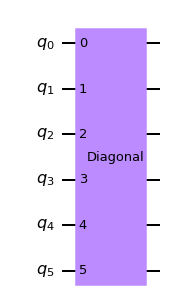

In [13]:
# One of qiskit's oracles
n = 6
oracle = grover_problem_oracle(n, variant=random.randint(0, 100000), print_solutions = True) 
oracle.draw('mpl')

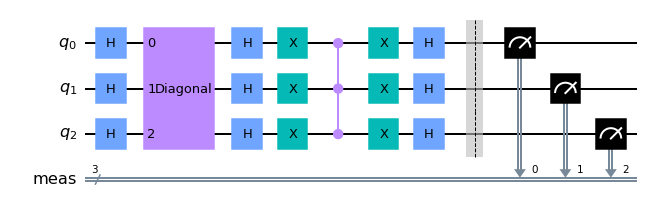

Running on current least busy device:  ibmq_lima
Job Status: job has successfully run


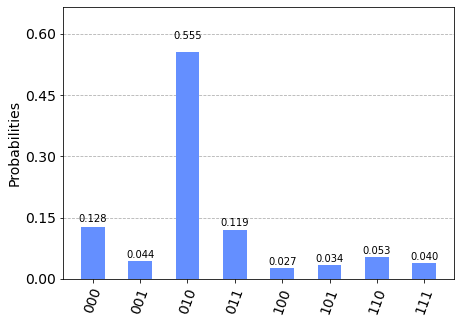

In [12]:
# Input the number of solutions!
num_solutions = 1
iterations = int(np.sqrt(n / num_solutions))
results = GroverSolver(oracle, iterations, n, simulation=False)